# Assignment 9: GBDT

#### Response Coding: Example

In [0]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('averaged_perceptron_tagger')
# import nltk
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

for_sentiment = 'a person is a person no matter how small dr seuss i teach the smallest students with the biggest enthusiasm \
for learning my students learn in many different ways using all of our senses and multiple intelligences i use a wide range\
of techniques to help all my students succeed students in my class come from a variety of different backgrounds which makes\
for wonderful sharing of experiences and cultures including native americans our school is a caring community of successful \
learners which can be seen through collaborative student project based learning in and out of the classroom kindergarteners \
in my class love to work with hands on materials and have many different opportunities to practice a skill before it is\
mastered having the social skills to work cooperatively with friends is a crucial aspect of the kindergarten curriculum\
montana is the perfect place to learn about agriculture and nutrition my students love to role play in our pretend kitchen\
in the early childhood classroom i have had several kids ask me can we try cooking with real food i will take their idea \
and create common core cooking lessons where we learn important math and writing concepts while cooking delicious healthy \
food for snack time my students will have a grounded appreciation for the work that went into making the food and knowledge \
of where the ingredients came from as well as how it is healthy for their bodies this project would expand our learning of \
nutrition and agricultural cooking recipes by having us peel our own apples to make homemade applesauce make our own bread \
and mix up healthy plants from our classroom garden in the spring we will also create our own cookbooks to be printed and \
shared with families students will gain math and literature skills as well as a life long enjoyment for healthy cooking \
nannan'
ss = sid.polarity_scores(for_sentiment)

for k in ss:
    print('{0}: {1}, '.format(k, ss[k]), end='')

# we can use these 4 things as features/attributes (neg, neu, pos, compound)
# neg: 0.0, neu: 0.753, pos: 0.247, compound: 0.93

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
neg: 0.01, neu: 0.745, pos: 0.245, compound: 0.9975, 

<h1>1. GBDT (xgboost/lightgbm) </h1>

## 1.1 Loading Data

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
import os

#from plotly import plotly
#import plotly.offline as offline
#import plotly.graph_objs as go
#offline.init_notebook_mode()
from collections import Counter

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link='https://drive.google.com/open?id=17UdaINmxF7AIju_Z947-eLbMSk7LQH55'
fluff, id = link.split('=')





In [0]:
import pandas
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('preprocessed_data.csv')  
data = pandas.read_csv('preprocessed_data.csv')
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [0]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

#X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [0]:

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer1 = TfidfVectorizer(min_df=10,max_features=5000)


vectorizer1.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer1.transform(X_train['essay'].values)
#X_cv_essay_tfidf = vectorizer1.transform(X_cv['essay'].values)
X_test_essay_tfidf = vectorizer1.transform(X_test['essay'].values)



In [0]:
from scipy.sparse import csr_matrix
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from scipy.sparse import vstack
# import nltk
nltk.download('vader_lexicon')
train=[]

sid = SentimentIntensityAnalyzer()
for i in range(73196):
  rb=[]
  x = str(X_train_essay_tfidf[i,:])
  for_sentiment = x
  ss = sid.polarity_scores(for_sentiment)
  for k in ss:
    rb.append(ss[k])
  train.append(rb)

      
    


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [0]:
from scipy.sparse import csr_matrix
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from scipy.sparse import vstack
# import nltk
nltk.download('vader_lexicon')
test=[]

sid = SentimentIntensityAnalyzer()
for i in range(36052):
  rb=[]
  x = str(X_test_essay_tfidf[i,:])
  for_sentiment = x
  ss = sid.polarity_scores(for_sentiment)
  for k in ss:
    rb.append(ss[k])
  test.append(rb)

    


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [0]:
train=np.array(train)
#cv=np.array(cv)
test=np.array(test)


In [0]:
from scipy.sparse import hstack
X_train_essay_tfidf_se= hstack((X_train_essay_tfidf,train)).tocsr()
#X_cv_essay_tfidf_se= hstack((X_cv_essay_tfidf,cv)).tocsr()
X_test_essay_tfidf_se= hstack((X_test_essay_tfidf,test)).tocsr()



<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

In [0]:
import pandas
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('preprocessed_data.csv')  
data = pandas.read_csv('preprocessed_data.csv')
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)



In [0]:
def coun(name_zero,name_one):
  
  return name_zero,name_one

In [0]:
from prettytable import PrettyTable
    
table_teacher_prefix = PrettyTable()
#column_names = ["Class=0", "Area", "Population", "Annual Rainfall"]
table_teacher_prefix.field_names = ["teacher_prefix","Class=0","Class=1"]
name_done=[]
name_zero_all=[]
name_one_all=[]
for i in range(73196):
  name_zero=0
  name_one=0
  no_name=0
  name=X_train['teacher_prefix'].iloc[i]
  if name not in name_done:
    for j in range(73196):
      dup_name=X_train['teacher_prefix'].iloc[j]
    
      if name==dup_name:
        no_name+=1
        if y_train[j]==0:
          name_zero+=1
        else:
          name_one+=1
    name_done.append(name)
    name_zero_all.append(name_zero)
    name_one_all.append(name_one)
for i in range(len(name_done)):
  table_teacher_prefix.add_row([name_done[i],name_zero_all[i],name_one_all[i]])  
  #table_teacher_prefix.add_column("Class=0",[name_zero])



train=[]
state_0_all_1=[]
state_1_all_1=[]
state_all_1=[]
for i in range(73196):
  state_0_all=[]
  state_1_all=[]
  state_all=[]
  rb=[]
  state_0=0
  state_1=0
  state=0
  x = X_train['teacher_prefix'].iloc[i]
  for j in range(len(name_done)):
    if x==name_done[j]:
      total=name_zero_all[j]+name_one_all[j]
      
     

      state_0=name_zero_all[j]/total
      state_1=name_one_all[j]/total
      if state_0>state_1:
        state=0
      else:
        state=1
      
    else:
      continue
    state_0_all.append(state_0)
    state_1_all.append(state_1)
    state_all.append(state)
  state_0_all_1.append(state_0_all)
  state_1_all_1.append(state_1_all)
  state_all_1.append(state_all) 

state_0_all_1=np.array(state_0_all_1)
state_1_all_1=np.array(state_1_all_1)
state_all_1=np.array(state_all_1)

  

      
    


In [0]:
from scipy.sparse import hstack

#X_train_teacher_prefix_csr= hstack(state_0_all_1,state_1_all_1)
X_train_teacher_prefix_csr=np.concatenate((state_0_all_1,state_1_all_1,state_all_1),axis=1)



In [0]:
from prettytable import PrettyTable
    
table_school_state = PrettyTable()
#column_names = ["Class=0", "Area", "Population", "Annual Rainfall"]
table_school_state.field_names = ["school_state","Class=0","Class=1"]
name_done_school_state=[]
name_zero_all_school_state=[]
name_one_all_school_state=[]
for i in range(73196):
  name_zero=0
  name_one=0
  no_name=0
  name=X_train['school_state'].iloc[i]
  if name not in name_done_school_state:
    for j in range(73196):
      dup_name=X_train['school_state'].iloc[j]
    
      if name==dup_name:
        no_name+=1
        if y_train[j]==0:
          name_zero+=1
        else:
          name_one+=1
    name_done_school_state.append(name)
    name_zero_all_school_state.append(name_zero)
    name_one_all_school_state.append(name_one)
for i in range(len(name_done_school_state)):
  table_school_state.add_row([name_done_school_state[i],name_zero_all_school_state[i],name_one_all_school_state[i]])  
  #table_teacher_prefix.add_column("Class=0",[name_zero])


  





state_0_all_1_school_state=[]
state_1_all_1_school_state=[]
state_all_1_school_state=[]
for i in range(73196):
  state_0_all_school_state=[]
  state_1_all_school_state=[]
  state_all_school_state=[]
  rb=[]
  state_0_school_state=0
  state_1_school_state=0
  state_school_state=0
  x = X_train['school_state'].iloc[i]
  for j in range(len(name_done_school_state)):
    if x==name_done_school_state[j]:
      total=name_zero_all_school_state[j]+name_one_all_school_state[j]
      
     

      state_0_school_state=name_zero_all_school_state[j]/total
      state_1_school_state=name_one_all_school_state[j]/total
      if state_0_school_state>state_1_school_state:
        state_school_state=0
      else:
        state_school_state=1
      
    else:
      continue
    state_0_all_school_state.append(state_0_school_state)
    state_1_all_school_state.append(state_1_school_state)
    state_all_school_state.append(state_school_state)
  state_0_all_1_school_state.append(state_0_all_school_state)
  state_1_all_1_school_state.append(state_1_all_school_state)
  state_all_1_school_state.append(state_all_school_state) 

state_0_all_1_school_state=np.array(state_0_all_1_school_state)
state_1_all_1_school_state=np.array(state_1_all_1_school_state)
state_all_1_school_state=np.array(state_all_1_school_state)


In [0]:
X_train_school_state_csr=np.concatenate((state_0_all_1_school_state,state_1_all_1_school_state,state_all_1_school_state),axis=1)


In [0]:
from prettytable import PrettyTable
    
table_project_grade_category = PrettyTable()
#column_names = ["Class=0", "Area", "Population", "Annual Rainfall"]
table_project_grade_category.field_names = ["project_grade_category","Class=0","Class=1"]
name_done_project_grade_category=[]
name_zero_all_project_grade_category=[]
name_one_all_project_grade_category=[]
for i in range(73196):
  name_zero=0
  name_one=0
  no_name=0
  name=X_train['project_grade_category'].iloc[i]
  if name not in name_done_project_grade_category:
    for j in range(73196):
      dup_name=X_train['project_grade_category'].iloc[j]
    
      if name==dup_name:
        no_name+=1
        if y_train[j]==0:
          name_zero+=1
        else:
          name_one+=1
    name_done_project_grade_category.append(name)
    name_zero_all_project_grade_category.append(name_zero)
    name_one_all_project_grade_category.append(name_one)
for i in range(len(name_done_project_grade_category)):
  table_project_grade_category.add_row([name_done_project_grade_category[i],name_zero_all_project_grade_category[i],name_one_all_project_grade_category[i]])  
  #table_teacher_prefix.add_column("Class=0",[name_zero])


  



state_0_all_1_project_grade_category=[]
state_1_all_1_project_grade_category=[]
state_all_1_project_grade_category=[]
for i in range(73196):
  state_0_all_project_grade_category=[]
  state_1_all_project_grade_category=[]
  state_all_project_grade_category=[]
  rb=[]
  state_0_project_grade_category=0
  state_1_project_grade_categorye=0
  state_project_grade_category=0
  x = X_train['project_grade_category'].iloc[i]
  for j in range(len(name_done_project_grade_category)):
    if x==name_done_project_grade_category[j]:
      total=name_zero_all_project_grade_category[j]+name_one_all_project_grade_category[j]
      
     

      state_0_project_grade_category=name_zero_all_project_grade_category[j]/total
      state_1_project_grade_category=name_one_all_project_grade_category[j]/total
      if state_0_project_grade_category>state_1_project_grade_category:
        state_project_grade_category=0
      else:
        state_project_grade_category=1
      
    else:
      continue
    state_0_all_project_grade_category.append(state_0_project_grade_category)
    state_1_all_project_grade_category.append(state_1_project_grade_category)
    state_all_project_grade_category.append(state_project_grade_category)
  state_0_all_1_project_grade_category.append(state_0_all_project_grade_category)
  state_1_all_1_project_grade_category.append(state_1_all_project_grade_category)
  state_all_1_project_grade_category.append(state_all_project_grade_category) 

state_0_all_1_project_grade_category=np.array(state_0_all_1_project_grade_category)
state_1_all_1_project_grade_category=np.array(state_1_all_1_project_grade_category)
state_all_1_project_grade_category=np.array(state_all_1_project_grade_category)


In [0]:
X_train_project_grade_category_csr=np.concatenate((state_0_all_1_project_grade_category,state_1_all_1_project_grade_category,state_all_1_project_grade_category),axis=1)


In [0]:
from prettytable import PrettyTable
import re  
table_clean_categories = PrettyTable()
#column_names = ["Class=0", "Area", "Population", "Annual Rainfall"]
table_clean_categories.field_names = ["clean_categories","Class=0","Class=1"]
name_done_clean_categories=[]
name_zero_all_clean_categories=[]
name_one_all_clean_categories=[]
name_zero=0
name_one=0
no_name=0
count=0
o=0
for i in range(73196):
  
  c=[]
  name=X_train['clean_categories'].iloc[i]
  #print(name)
  name1 = re.split("\s", name)
 
  for f in range(len(name1)):
    for d in range(len(name_done_clean_categories)):
      
      b=re.search(name1[f],name_done_clean_categories[d])
      c.append(b)
  #print(c)
  nTemp = None
  bEqual = True
    
  for item in c:
    if nTemp != item:
      bEqual = False
      break
      
  if bEqual==True:
    for z in name1:
      name_done_clean_categories.append(z)
for y in  name_done_clean_categories:
  name_zero=0
  name_one=0
  no_name=0
  for j in range(73196):
    dup_name=X_train['clean_categories'].iloc[j]
    dup_name1 = re.split("\s", dup_name)
    for h in range(len(dup_name1)):
      if y==dup_name1[h]:
        #print(y_train[j)
        if y_train[j]==0:
          name_zero+=1
        else:
          name_one+=1
  name_zero_all_clean_categories.append(name_zero)
  name_one_all_clean_categories.append(name_one)
for i in range(len(name_done_clean_categories)):
  table_clean_categories.add_row([name_done_clean_categories[i],name_zero_all_clean_categories[i],name_one_all_clean_categories[i]])  
  #table_teacher_prefix.add_column("Class=0",[name_zero])


  








In [0]:
state_0_all_1_clean_categories=[]
state_1_all_1_clean_categories=[]
state_all_1_clean_categories=[]
for i in range(53196):
  state_0_all_clean_categories=[]
  state_1_all_clean_categories=[]
  state_all_clean_categories=[]
  rb=[]
  state_0_clean_categories=0
  state_1_clean_categories=0
  state_clean_categories=0
  x = X_train['clean_categories'].iloc[i]
  #print(x)
  #dup_name_x=X_train['clean_categories'].iloc[j]
  dup_name1_x = re.split("\s",x)
  for h in range(len(dup_name1_x)):
    for j in range(len(name_done_clean_categories)):
      if dup_name1_x[h]==name_done_clean_categories[j]:
        total=name_zero_all_clean_categories[j]+name_one_all_clean_categories[j]
        state_0_clean_categories=name_zero_all_clean_categories[j]/total
        state_1_clean_categories=name_one_all_clean_categories[j]/total
        #print(total)
        #print(state_0_clean_categories)
        #print(state_1_clean_categories)
        if state_0_clean_categories>state_1_clean_categories:
          state_clean_categories=0
        else:
          state_clean_categories=1
      
      else:
        continue
    

    state_0_all_clean_categories.append(state_0_clean_categories)
    state_1_all_clean_categories.append(state_1_clean_categories)
    state_all_clean_categories.append(state_clean_categories)
  if(len(state_0_all_clean_categories)>1 or len(state_1_all_clean_categories)>1 ):
    state_0_all_clean_categories=[max(state_0_all_clean_categories)]
    state_1_all_clean_categories=[max(state_1_all_clean_categories)]
    state_all_clean_categories=[max(state_all_clean_categories,key=state_all_clean_categories.count)]
  
  state_0_all_1_clean_categories.append(state_0_all_clean_categories)
  state_1_all_1_clean_categories.append(state_1_all_clean_categories)
  state_all_1_clean_categories.append(state_all_clean_categories) 



In [0]:
state_0_all_1_clean_categories_2=[]
state_1_all_1_clean_categories_2=[]
state_all_1_clean_categories_2=[]
for i in range(53196,73196):
  state_0_all_clean_categories=[]
  state_1_all_clean_categories=[]
  state_all_clean_categories=[]
  rb=[]
  state_0_clean_categories=0
  state_1_clean_categories=0
  state_clean_categories=0
  x = X_train['clean_categories'].iloc[i]
  #print(x)
  #dup_name_x=X_train['clean_categories'].iloc[j]
  dup_name1_x = re.split("\s",x)
  for h in range(len(dup_name1_x)):
    for j in range(len(name_done_clean_categories)):
      if dup_name1_x[h]==name_done_clean_categories[j]:
        total=name_zero_all_clean_categories[j]+name_one_all_clean_categories[j]
        state_0_clean_categories=name_zero_all_clean_categories[j]/total
        state_1_clean_categories=name_one_all_clean_categories[j]/total
        #print(total)
        #print(state_0_clean_categories)
        #print(state_1_clean_categories)
        if state_0_clean_categories>state_1_clean_categories:
          state_clean_categories=0
        else:
          state_clean_categories=1
      
      else:
        continue
    

    state_0_all_clean_categories.append(state_0_clean_categories)
    state_1_all_clean_categories.append(state_1_clean_categories)
    state_all_clean_categories.append(state_clean_categories)
  if(len(state_0_all_clean_categories)>1 or len(state_1_all_clean_categories)>1 ):
    state_0_all_clean_categories=[max(state_0_all_clean_categories)]
    state_1_all_clean_categories=[max(state_1_all_clean_categories)]
    state_all_clean_categories=[max(state_all_clean_categories,key=state_all_clean_categories.count)]

  state_0_all_1_clean_categories_2.append(state_0_all_clean_categories)
  state_1_all_1_clean_categories_2.append(state_1_all_clean_categories)
  state_all_1_clean_categories_2.append(state_all_clean_categories) 



In [0]:
m=state_0_all_1_clean_categories+state_0_all_1_clean_categories_2
n=state_1_all_1_clean_categories+state_1_all_1_clean_categories_2
p=state_all_1_clean_categories+state_all_1_clean_categories_2
state_0_a=np.array(m)
state_1_a=np.array(n)
state_all_a=np.array(p)



In [0]:
X_train_clean_categories_csr=np.concatenate((state_0_a,state_1_a,state_all_a),axis=1)


In [0]:
from prettytable import PrettyTable
import re  
table_clean_subcategories = PrettyTable()
#column_names = ["Class=0", "Area", "Population", "Annual Rainfall"]
table_clean_subcategories.field_names = ["clean_subcategories","Class=0","Class=1"]
name_done_clean_subcategories=[]
name_zero_all_clean_subcategories=[]
name_one_all_clean_subcategories=[]
name_zero=0
name_one=0
no_name=0
count=0
o=0
for i in range(73196):
  
  c=[]
  name=X_train['clean_subcategories'].iloc[i]
  
  name1 = re.split("\s", name)
  #print(name1)
  #print(name_done_clean_subcategories)
  for f in range(len(name1)):
    for d in range(len(name_done_clean_subcategories)):
      
      b=re.search(name1[f],name_done_clean_subcategories[d])
      c.append(b)
  #print(c)
  nTemp = None
  bEqual = True
    
  for item in c:
    if nTemp != item:
      bEqual = False
      break
      
  if bEqual==True:
    for z in name1:
      name_done_clean_subcategories.append(z)
for y in  name_done_clean_subcategories:
  name_zero=0
  name_one=0
  no_name=0
  for j in range(73196):
    dup_name=X_train['clean_subcategories'].iloc[j]
    dup_name1 = re.split("\s", dup_name)
    for h in range(len(dup_name1)):
      if y==dup_name1[h]:
        #print(y_train[j)
        if y_train[j]==0:
          name_zero+=1
        else:
          name_one+=1
  name_zero_all_clean_subcategories.append(name_zero)
  name_one_all_clean_subcategories.append(name_one)
for i in range(len(name_done_clean_subcategories)):
  table_clean_subcategories.add_row([name_done_clean_subcategories[i],name_zero_all_clean_subcategories[i],name_one_all_clean_subcategories[i]])  
  #table_teacher_prefix.add_column("Class=0",[name_zero])


  




  

             











In [0]:
state_0_all_1_clean_subcategories_2=[]
state_1_all_1_clean_subcategories_2=[]
state_all_1_clean_subcategories_2=[]
for i in range(53196,73196):
  state_0_all_clean_subcategories=[]
  state_1_all_clean_subcategories=[]
  state_all_clean_subcategories=[]
  rb=[]
  state_0_clean_subcategories=0
  state_1_clean_subcategories=0
  state_clean_subcategories=0
  x = X_train['clean_subcategories'].iloc[i]
  #print(x)
  #dup_name_x=X_train['clean_categories'].iloc[j]
  dup_name1_x = re.split("\s",x)
  for h in range(len(dup_name1_x)):
    for j in range(len(name_done_clean_subcategories)):
      if dup_name1_x[h]==name_done_clean_subcategories[j]:
        total=name_zero_all_clean_subcategories[j]+name_one_all_clean_subcategories[j]
        state_0_clean_subcategories=name_zero_all_clean_subcategories[j]/total
        state_1_clean_subcategories=name_one_all_clean_subcategories[j]/total
        #print(total)
        #print(state_0_clean_categories)
        #print(state_1_clean_categories)
        if state_0_clean_subcategories>state_1_clean_subcategories:
          state_clean_subcategories=0
        else:
          state_clean_subcategories=1
      
      else:
        continue
    

    state_0_all_clean_subcategories.append(state_0_clean_subcategories)
    state_1_all_clean_subcategories.append(state_1_clean_subcategories)
    state_all_clean_subcategories.append(state_clean_subcategories)
  if(len(state_0_all_clean_subcategories)>1 or len(state_1_all_clean_subcategories)>1 ):
    state_0_all_clean_subcategories=[max(state_0_all_clean_subcategories)]
    state_1_all_clean_subcategories=[max(state_1_all_clean_subcategories)]
    state_all_clean_subcategories=[max(state_all_clean_subcategories,key=state_all_clean_subcategories.count)]
  
  state_0_all_1_clean_subcategories_2.append(state_0_all_clean_subcategories)
  state_1_all_1_clean_subcategories_2.append(state_1_all_clean_subcategories)
  state_all_1_clean_subcategories_2.append(state_all_clean_subcategories) 



In [0]:
state_0_all_1_clean_subcategories=[]
state_1_all_1_clean_subcategories=[]
state_all_1_clean_subcategories=[]
for i in range(53196):
  state_0_all_clean_subcategories=[]
  state_1_all_clean_subcategories=[]
  state_all_clean_subcategories=[]
  rb=[]
  state_0_clean_subcategories=0
  state_1_clean_subcategories=0
  state_clean_subcategories=0
  x = X_train['clean_subcategories'].iloc[i]
  #print(x)
  #dup_name_x=X_train['clean_categories'].iloc[j]
  dup_name1_x = re.split("\s",x)
  for h in range(len(dup_name1_x)):
    for j in range(len(name_done_clean_subcategories)):
      if dup_name1_x[h]==name_done_clean_subcategories[j]:
        total=name_zero_all_clean_subcategories[j]+name_one_all_clean_subcategories[j]
        state_0_clean_subcategories=name_zero_all_clean_subcategories[j]/total
        state_1_clean_subcategories=name_one_all_clean_subcategories[j]/total
        #print(total)
        #print(state_0_clean_categories)
        #print(state_1_clean_categories)
        if state_0_clean_subcategories>state_1_clean_subcategories:
          state_clean_subcategories=0
        else:
          state_clean_subcategories=1
      
      else:
        continue
    

    state_0_all_clean_subcategories.append(state_0_clean_subcategories)
    state_1_all_clean_subcategories.append(state_1_clean_subcategories)
    state_all_clean_subcategories.append(state_clean_subcategories)
  if(len(state_0_all_clean_subcategories)>1 or len(state_1_all_clean_subcategories)>1 ):
    state_0_all_clean_subcategories=[max(state_0_all_clean_subcategories)]
    state_1_all_clean_subcategories=[max(state_1_all_clean_subcategories)]
    state_all_clean_subcategories=[max(state_all_clean_subcategories,key=state_all_clean_subcategories.count)]
  
  state_0_all_1_clean_subcategories.append(state_0_all_clean_subcategories)
  state_1_all_1_clean_subcategories.append(state_1_all_clean_subcategories)
  state_all_1_clean_subcategories.append(state_all_clean_subcategories) 



In [0]:
m_sub=state_0_all_1_clean_categories+state_0_all_1_clean_categories_2
n_sub=state_1_all_1_clean_categories+state_1_all_1_clean_categories_2
p_sub=state_all_1_clean_categories+state_all_1_clean_categories_2
state_0_sub=np.array(m_sub)
state_1_sub=np.array(n_sub)
state_all_sub=np.array(p_sub)


In [0]:
X_train_clean_subcategories_csr=np.concatenate((state_0_sub,state_1_sub,state_all_sub),axis=1)


In [0]:
conunt=0
for i in range(len(name_zero_all_clean_subcategories)):
  conunt+=(name_zero_all_clean_subcategories[i])

conunt_one=0
for i in range(len(name_one_all_clean_subcategories)):
  conunt_one+=(name_one_all_clean_subcategories[i])


In [0]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
#X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))




In [0]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_number_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
#X_cv_number_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_number_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))





<h2>TEST SET</h2>

In [0]:




state_0_all_1_test=[]
state_1_all_1_test=[]
state_all_1_test=[]
for i in range(36052):
  state_0_all_test=[]
  state_1_all_test=[]
  state_all_test=[]
  rb=[]
  state_0_test=0
  state_1_test=0
  state_test=0
  x = X_test['teacher_prefix'].iloc[i]
  for j in range(len(name_done)):
    if x==name_done[j]:
      total=name_zero_all[j]+name_one_all[j]
      
     

      state_0_test=name_zero_all[j]/total
      state_1_test=name_one_all[j]/total
      if state_0_test>state_1_test:
        state_test=0
      else:
        state_test=1
      
    else:
      continue
    state_0_all_test.append(state_0_test)
    state_1_all_test.append(state_1_test)
    state_all_test.append(state_test)
  state_0_all_1_test.append(state_0_all_test)
  state_1_all_1_test.append(state_1_all_test)
  state_all_1_test.append(state_all_test) 

state_0_all_1_test=np.array(state_0_all_1_test)
state_1_all_1_test=np.array(state_1_all_1_test)
state_all_1_test=np.array(state_all_1_test)


      
    


In [0]:
X_test_csr=np.concatenate((state_0_all_1_test,state_1_all_1_test,state_all_1_test),axis=1)


In [0]:
count_zero=0
count_one=0
for i in y_test:
  if i==0:
    count_zero+=1
  else:
    count_one+=1


In [0]:
state_0_all_1_school_state_test=[]
state_1_all_1_school_state_test=[]
state_all_1_school_state_test=[]
for i in range(36052):
  state_0_all_school_state_test=[]
  state_1_all_school_state_test=[]
  state_all_school_state_test=[]
  rb=[]
  state_0_school_state_test=0
  state_1_school_state_test=0
  state_school_state_test=0
  x = X_test['school_state'].iloc[i]
  for j in range(len(name_done_school_state)):
    if x==name_done_school_state[j]:
      total=name_zero_all_school_state[j]+name_one_all_school_state[j]
      
     

      state_0_school_state_test=name_zero_all_school_state[j]/total
      state_1_school_state_test=name_one_all_school_state[j]/total
      if state_0_school_state_test>state_1_school_state_test:
        state_school_state_test=0
      else:
        state_school_state_test=1
      
    else:
      continue
    state_0_all_school_state_test.append(state_0_school_state_test)
    state_1_all_school_state_test.append(state_1_school_state_test)
    state_all_school_state_test.append(state_school_state_test)
  state_0_all_1_school_state_test.append(state_0_all_school_state_test)
  state_1_all_1_school_state_test.append(state_1_all_school_state_test)
  state_all_1_school_state_test.append(state_all_school_state_test) 

state_0_all_1_school_state_test=np.array(state_0_all_1_school_state_test)
state_1_all_1_school_state_test=np.array(state_1_all_1_school_state_test)
state_all_1_school_state_test=np.array(state_all_1_school_state_test)


In [0]:
X_test_school_state_csr=np.concatenate((state_0_all_1_school_state_test,state_1_all_1_school_state_test,state_all_1_school_state_test),axis=1)


In [0]:

state_0_all_1_project_grade_category_test=[]
state_1_all_1_project_grade_category_test=[]
state_all_1_project_grade_category_test=[]
for i in range(36052):
  state_0_all_project_grade_category_test=[]
  state_1_all_project_grade_category_test=[]
  state_all_project_grade_category_test=[]
  rb=[]
  state_0_project_grade_category_test=0
  state_1_project_grade_categorye_test=0
  state_project_grade_category_test=0
  x = X_test['project_grade_category'].iloc[i]
  for j in range(len(name_done_project_grade_category)):
    if x==name_done_project_grade_category[j]:
      total=name_zero_all_project_grade_category[j]+name_one_all_project_grade_category[j]
      
     

      state_0_project_grade_category_test=name_zero_all_project_grade_category[j]/total
      state_1_project_grade_category_test=name_one_all_project_grade_category[j]/total
      if state_0_project_grade_category_test>state_1_project_grade_category:
        state_project_grade_category_test=0
      else:
        state_project_grade_category_test=1
      
    else:
      continue
    state_0_all_project_grade_category_test.append(state_0_project_grade_category_test)
    state_1_all_project_grade_category_test.append(state_1_project_grade_category_test)
    state_all_project_grade_category_test.append(state_project_grade_category_test)
  state_0_all_1_project_grade_category_test.append(state_0_all_project_grade_category_test)
  state_1_all_1_project_grade_category_test.append(state_1_all_project_grade_category_test)
  state_all_1_project_grade_category_test.append(state_all_project_grade_category_test) 

state_0_all_1_project_grade_category_test=np.array(state_0_all_1_project_grade_category_test)
state_1_all_1_project_grade_category_test=np.array(state_1_all_1_project_grade_category_test)
state_all_1_project_grade_category_test=np.array(state_all_1_project_grade_category_test)


In [0]:
X_test_project_grade_category_csr=np.concatenate((state_0_all_1_project_grade_category_test,state_1_all_1_project_grade_category_test,state_all_1_project_grade_category_test),axis=1)


In [0]:
state_0_all_1_clean_categories_2_t=[]
state_1_all_1_clean_categories_2_t=[]
state_all_1_clean_categories_2_t=[]
for i in range(36052):
  state_0_all_clean_categories_t=[]
  state_1_all_clean_categories_t=[]
  state_all_clean_categories_t=[]
  rb=[]
  state_0_clean_categories_t=0
  state_1_clean_categories_t=0
  state_clean_categories_t=0
  x = X_test['clean_categories'].iloc[i]
  #print(x)
  #dup_name_x=X_train['clean_categories'].iloc[j]
  dup_name1_x = re.split("\s",x)
  for h in range(len(dup_name1_x)):
    for j in range(len(name_done_clean_categories)):
      if dup_name1_x[h]==name_done_clean_categories[j]:
        total=name_zero_all_clean_categories[j]+name_one_all_clean_categories[j]
        state_0_clean_categories_t=name_zero_all_clean_categories[j]/total
        state_1_clean_categories_t=name_one_all_clean_categories[j]/total
        #print(total)
        #print(state_0_clean_categories)
        #print(state_1_clean_categories)
        if state_0_clean_categories_t>state_1_clean_categories_t:
          state_clean_categories_t=0
        else:
          state_clean_categories_t=1
      
      else:
        continue
    

    state_0_all_clean_categories_t.append(state_0_clean_categories_t)
    state_1_all_clean_categories_t.append(state_1_clean_categories_t)
    state_all_clean_categories_t.append(state_clean_categories_t)
  if(len(state_0_all_clean_categories_t)>1 or len(state_1_all_clean_categories_t)>1 ):
    state_0_all_clean_categories_t=[max(state_0_all_clean_categories_t)]
    state_1_all_clean_categories_t=[max(state_1_all_clean_categories_t)]
    state_all_clean_categories_t=[max(state_all_clean_categories_t,key=state_all_clean_categories_t.count)]

  state_0_all_1_clean_categories_2_t.append(state_0_all_clean_categories_t)
  state_1_all_1_clean_categories_2_t.append(state_1_all_clean_categories_t)
  state_all_1_clean_categories_2_t.append(state_all_clean_categories_t) 
state_0_all_1_clean_categories_2_t=np.array(state_0_all_1_clean_categories_2_t)
state_1_all_1_clean_categories_2_t=np.array(state_1_all_1_clean_categories_2_t)
state_all_1_clean_categories_2_t=np.array(state_all_1_clean_categories_2_t)



In [0]:
X_test_clean_categories_csr=np.concatenate((state_0_all_1_clean_categories_2_t,state_1_all_1_clean_categories_2_t,state_all_1_clean_categories_2_t),axis=1)


In [0]:
state_0_all_1_clean_subcategories_t=[]
state_1_all_1_clean_subcategories_t=[]
state_all_1_clean_subcategories_t=[]
for i in range(36052):
  state_0_all_clean_subcategories_t=[]
  state_1_all_clean_subcategories_t=[]
  state_all_clean_subcategories_t=[]
  rb=[]
  state_0_clean_subcategories_t=0
  state_1_clean_subcategories_t=0
  state_clean_subcategories_t=0
  x = X_test['clean_subcategories'].iloc[i]
  #print(x)
  #dup_name_x=X_train['clean_categories'].iloc[j]
  dup_name1_x = re.split("\s",x)
  for h in range(len(dup_name1_x)):
    for j in range(len(name_done_clean_subcategories)):
      if dup_name1_x[h]==name_done_clean_subcategories[j]:
        total=name_zero_all_clean_subcategories[j]+name_one_all_clean_subcategories[j]
        state_0_clean_subcategories_t=name_zero_all_clean_subcategories[j]/total
        state_1_clean_subcategories_t=name_one_all_clean_subcategories[j]/total
        #print(total)
        #print(state_0_clean_categories)
        #print(state_1_clean_categories)
        if state_0_clean_subcategories_t>state_1_clean_subcategories_t:
          state_clean_subcategories_t=0
        else:
          state_clean_subcategories_t=1
      
      else:
        continue
    

    state_0_all_clean_subcategories_t.append(state_0_clean_subcategories_t)
    state_1_all_clean_subcategories_t.append(state_1_clean_subcategories_t)
    state_all_clean_subcategories_t.append(state_clean_subcategories_t)
  if(len(state_0_all_clean_subcategories_t)>1 or len(state_1_all_clean_subcategories_t)>1 ):
    state_0_all_clean_subcategories_t=[max(state_0_all_clean_subcategories_t)]
    state_1_all_clean_subcategories_t=[max(state_1_all_clean_subcategories_t)]
    state_all_clean_subcategories_t=[max(state_all_clean_subcategories_t,key=state_all_clean_subcategories_t.count)]
  
  state_0_all_1_clean_subcategories_t.append(state_0_all_clean_subcategories_t)
  state_1_all_1_clean_subcategories_t.append(state_1_all_clean_subcategories_t)
  state_all_1_clean_subcategories_t.append(state_all_clean_subcategories_t) 
state_0_all_1_clean_subcategories_t=np.array(state_0_all_1_clean_subcategories_t)
state_1_all_1_clean_subcategories_t=np.array(state_1_all_1_clean_subcategories_t)
state_all_1_clean_subcategories_t=np.array(state_all_1_clean_subcategories_t)



In [0]:
X_test_clean_subcategories_csr=np.concatenate((state_0_all_1_clean_subcategories_t,state_1_all_1_clean_subcategories_t,state_all_1_clean_subcategories_t),axis=1)


In [0]:
X_train_essay_tfidf_se.shape
X_train_teacher_prefix_csr.shape

(73196, 3)

In [0]:

from scipy.sparse import hstack
X_train_tfidf= hstack((X_train_essay_tfidf_se, X_train_teacher_prefix_csr,X_train_school_state_csr,X_train_project_grade_category_csr, X_train_clean_categories_csr, X_train_clean_subcategories_csr, X_train_price_norm, X_train_number_norm)).tocsr()
X_test_tfidf= hstack((X_test_essay_tfidf_se, X_test_csr, X_test_school_state_csr, X_test_project_grade_category_csr,X_test_clean_categories_csr, X_test_clean_subcategories_csr, X_test_price_norm, X_test_number_norm)).tocsr()


In [0]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier







parameters = {
 'max_leaf_nodes':range(3,10,2),
 'colsample_bytree':[0.7,0.8,0.9]
}
alpha = XGBClassifier()
#preds = bst.predict(dtest)

clf1 = GridSearchCV(alpha, parameters,cv=3, scoring='roc_auc',return_train_score=True)
best_alpha1=clf1.fit(X_train_tfidf, y_train)

results1 = pd.DataFrame.from_dict(clf1.cv_results_)
#print(results)
#results1 = results1.sort_values(['param_max_depth'])

train_auc_set2= results1['mean_train_score']
train_auc_std_set2= results1['std_train_score']
cv_auc_set2 = results1['mean_test_score'] 
cv_auc_std_set2= results1['std_test_score']
#K2 =  results1['param_max_depth']

print('The parameters combination that would give best accuracy is : ')
print(clf1.best_params_)
print('The best accuracy achieved after parameter tuning via grid search is : ', clf1.best_score_)


The parameters combination that would give best accuracy is : 
{'colsample_bytree': 0.9, 'max_leaf_nodes': 3}
The best accuracy achieved after parameter tuning via grid search is :  0.5609771473626092


HEAT MAP-TRAIN DATA


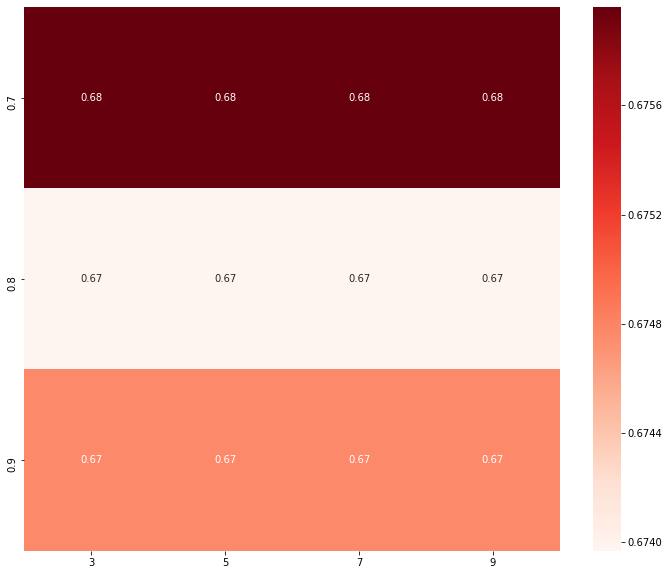

HEAT MAP-CV DATA


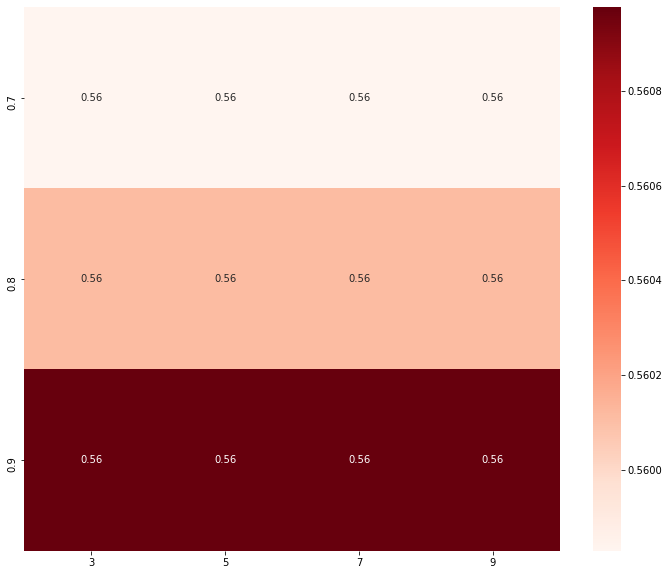

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(12,10))
print("HEAT MAP-TRAIN DATA")
data_tr={'3':[train_auc_set2.iloc[0],train_auc_set2.iloc[4],train_auc_set2.iloc[8]],'5':[train_auc_set2.iloc[1],train_auc_set2.iloc[5],train_auc_set2.iloc[9]],'7':[train_auc_set2.iloc[2],train_auc_set2.iloc[6],train_auc_set2.iloc[10]],'9':[train_auc_set2.iloc[3],train_auc_set2.iloc[7],train_auc_set2.iloc[11]]}                                                                                                                                                                              
df_tr=pd.DataFrame(data_tr,index=[0.7,0.8,0.9])
sns.heatmap(df_tr, annot=True, cmap=plt.cm.Reds)
plt.show()

plt.figure(figsize=(12,10))
print("HEAT MAP-CV DATA")
data_test={'3':[cv_auc_set2.iloc[0],cv_auc_set2.iloc[4],cv_auc_set2.iloc[8]],'5':[cv_auc_set2.iloc[1],cv_auc_set2.iloc[5],cv_auc_set2.iloc[9]],'7':[cv_auc_set2.iloc[2],cv_auc_set2.iloc[6],cv_auc_set2.iloc[10]],'9':[cv_auc_set2.iloc[3],cv_auc_set2.iloc[7],cv_auc_set2.iloc[11]]}
df_test=pd.DataFrame(data_test,index=[0.7,0.8,0.9])

sns.heatmap(df_test, annot=True, cmap=plt.cm.Reds)
plt.show()

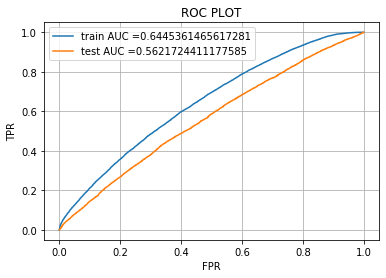

In [0]:
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier




from xgboost import XGBClassifier





clf= XGBClassifier(colsample_bytree=0.8, max_leaf_nodes= 3)



clf.fit(X_train_tfidf,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs


y_train_pred=(clf.predict_proba(X_train_tfidf)[:,1])
y_test_pred=(clf.predict_proba(X_test_tfidf)[:,1])

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC PLOT")
plt.grid()
plt.show()


In [0]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score



clf =XGBClassifier(colsample_bytree=0.8, max_leaf_nodes= 3)
clf.fit(X_train_tfidf,y_train)
 
y_predicted = clf.predict(X_test_tfidf)
f1_score(y_test, y_predicted)
cm = confusion_matrix(y_test, y_predicted)
tn, fp, fn, tp = cm.ravel()
print(cm)

[[    0  5459]
 [    0 30593]]


<h2>SET 2</h2>

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link='https://drive.google.com/open?id=154kF75bCeNRu-sns7CJerlfwxew5isyd'
fluff, id1 = link.split('=')
print (id1)

154kF75bCeNRu-sns7CJerlfwxew5isyd


In [0]:
import pandas
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('preprocessed_data.csv') 
downloaded1 = drive.CreateFile({'id':id1}) 
downloaded1.GetContentFile('glove_vectors') 
data = pandas.read_csv('preprocessed_data.csv')
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)

In [0]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [0]:

y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)



In [0]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
#X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model_train = TfidfVectorizer()
tfidf_model_train.fit(X_train['essay'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_train = dict(zip(tfidf_model_train.get_feature_names(), list(tfidf_model_train.idf_)))
tfidf_words_train = set(tfidf_model_train.get_feature_names())









tfidf_model_test = TfidfVectorizer()
tfidf_model_test.fit(X_test['essay'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_test = dict(zip(tfidf_model_test.get_feature_names(), list(tfidf_model_test.idf_)))
tfidf_words_test = set(tfidf_model_test.get_feature_names())

In [0]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight_train =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words_train):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf_train = dictionary_train[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf_train) # calculating tfidf weighted w2v
            tf_idf_weight_train += tf_idf_train
    if tf_idf_weight_train != 0:
        vector /= tf_idf_weight_train
    tfidf_w2v_vectors_train.append(vector)

print(len(tfidf_w2v_vectors_train))
print(len(tfidf_w2v_vectors_train[0]))







tfidf_w2v_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight_test =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words_test):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf_test = dictionary_test[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf_test) # calculating tfidf weighted w2v
            tf_idf_weight_test += tf_idf_test
    if tf_idf_weight_test != 0:
        vector /= tf_idf_weight_test
    tfidf_w2v_vectors_test.append(vector)

print(len(tfidf_w2v_vectors_test))
print(len(tfidf_w2v_vectors_test[0]))




  0%|          | 49/36052 [00:00<01:13, 487.73it/s]

73196
300


100%|██████████| 36052/36052 [01:16<00:00, 470.80it/s]

36052
300


In [0]:


from scipy import sparse
tfidf_w2v_vectors_train=np.array(tfidf_w2v_vectors_train)

tfidf_w2v_vectors_train=sparse.csr_matrix(tfidf_w2v_vectors_train)

tfidf_w2v_vectors_test=np.array(tfidf_w2v_vectors_test)

tfidf_w2v_vectors_test=sparse.csr_matrix(tfidf_w2v_vectors_test)


In [0]:

from scipy.sparse import hstack
X_train_tfidf_w2v= hstack((tfidf_w2v_vectors_train,X_train_teacher_prefix_csr,X_train_school_state_csr,X_train_project_grade_category_csr, X_train_clean_categories_csr, X_train_clean_subcategories_csr, X_train_price_norm, X_train_number_norm))
X_test_tfidf_w2v= hstack((tfidf_w2v_vectors_test,X_test_csr, X_test_school_state_csr, X_test_project_grade_category_csr,X_test_clean_categories_csr, X_test_clean_subcategories_csr, X_test_price_norm, X_test_number_norm))
print(X_train_tfidf_w2v.shape)

print(X_test_tfidf_w2v.shape)

(73196, 317)
(36052, 317)


In [0]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier







parameters = {
 'max_leaf_nodes':range(3,10,2),
 'colsample_bytree':[0.7,0.8,0.9]
}
alpha = XGBClassifier()
#preds = bst.predict(dtest)

clf1 = GridSearchCV(alpha, parameters,cv=3, scoring='roc_auc',return_train_score=True)
best_alpha1=clf1.fit(X_train_tfidf_w2v, y_train)

results1 = pd.DataFrame.from_dict(clf1.cv_results_)
#print(results)
#results1 = results1.sort_values(['param_max_depth'])

train_auc_set2_w2v= results1['mean_train_score']
train_auc_std_set2_w2v= results1['std_train_score']
cv_auc_set2_w2v = results1['mean_test_score'] 
cv_auc_std_set2_w2v= results1['std_test_score']

print('The parameters combination that would give best accuracy is : ')
print(clf1.best_params_)
print('The best accuracy achieved after parameter tuning via grid search is : ', clf1.best_score_)


The parameters combination that would give best accuracy is : 
{'colsample_bytree': 0.9, 'max_leaf_nodes': 3}
The best accuracy achieved after parameter tuning via grid search is :  0.6857384785199699


HEAT MAP-TRAIN DATA


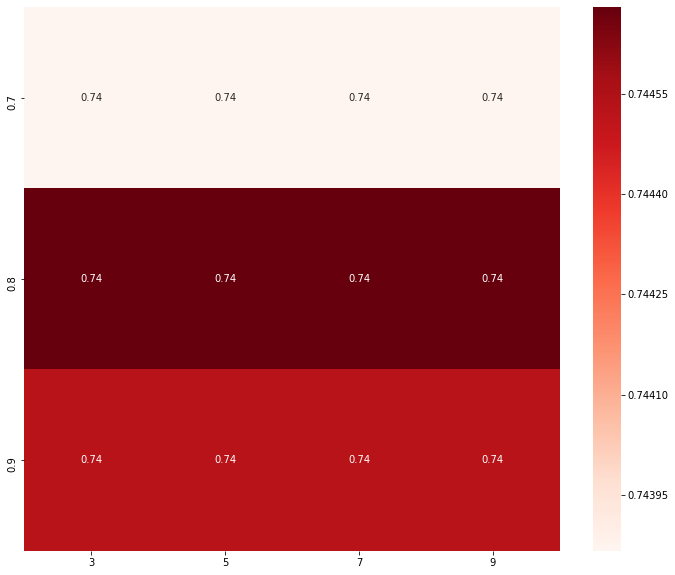

HEAT MAP-CV DATA


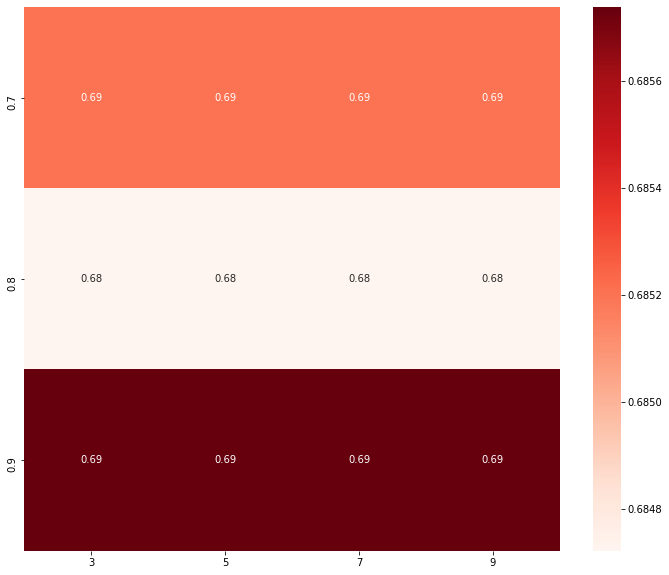

In [0]:



import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(12,10))
print("HEAT MAP-TRAIN DATA")
data_tr={'3':[train_auc_set2_w2v.iloc[0],train_auc_set2_w2v.iloc[4],train_auc_set2_w2v.iloc[8]],'5':[train_auc_set2_w2v.iloc[1],train_auc_set2_w2v.iloc[5],train_auc_set2_w2v.iloc[9]],'7':[train_auc_set2_w2v.iloc[2],train_auc_set2_w2v.iloc[6],train_auc_set2_w2v.iloc[10]],'9':[train_auc_set2_w2v.iloc[3],train_auc_set2_w2v.iloc[7],train_auc_set2_w2v.iloc[11]]}                                                                                                                                                                              
df_tr=pd.DataFrame(data_tr,index=[0.7,0.8,0.9])
sns.heatmap(df_tr, annot=True, cmap=plt.cm.Reds)
plt.show()

plt.figure(figsize=(12,10))
print("HEAT MAP-CV DATA")
data_test={'3':[cv_auc_set2_w2v.iloc[0],cv_auc_set2_w2v.iloc[4],cv_auc_set2_w2v.iloc[8]],'5':[cv_auc_set2_w2v.iloc[1],cv_auc_set2_w2v.iloc[5],cv_auc_set2_w2v.iloc[9]],'7':[cv_auc_set2_w2v.iloc[2],cv_auc_set2_w2v.iloc[6],cv_auc_set2_w2v.iloc[10]],'9':[cv_auc_set2_w2v.iloc[3],cv_auc_set2_w2v.iloc[7],cv_auc_set2_w2v.iloc[11]]}
df_test=pd.DataFrame(data_test,index=[0.7,0.8,0.9])

sns.heatmap(df_test, annot=True, cmap=plt.cm.Reds)
plt.show()

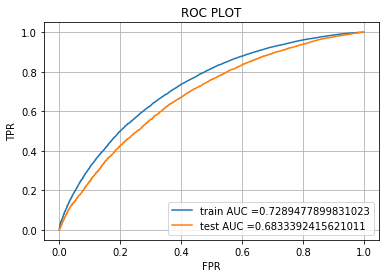

In [0]:
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier




clf = XGBClassifier(colsample_bytree=0.8, max_leaf_nodes= 3)




clf.fit(X_train_tfidf_w2v,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs


y_train_pred=(clf.predict_proba(X_train_tfidf_w2v)[:,1])
y_test_pred=(clf.predict_proba(X_test_tfidf_w2v)[:,1])

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC PLOT")
plt.grid()
plt.show()


In [0]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score



clf =XGBClassifier(colsample_bytree=0.8, max_leaf_nodes= 3)
clf.fit(X_train_tfidf_w2v,y_train)
 
y_predicted = clf.predict(X_test_tfidf_w2v)
f1_score(y_test, y_predicted)
cm = confusion_matrix(y_test, y_predicted)
print(cm)

[[    9  5450]
 [    8 30585]]


<h1>3. Summary</h1>



|vectorizer|Model|colsample_bytree|max_leaf_nodes|AUC
|---|---|---|---|---|
|TFIDF|GBDT|0.9|3|0.56
|TFIDF-W2V|GBDT|0.8|3|0.68
